In [1]:
!pip install pandas numpy gensim scikit-learn tensorflow matplotlib
!pip install nltk

In [2]:

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:

zipfile.ZipFile("/content/archive (1).zip", 'r').extractall("data/")

In [4]:

input_folder = "/content/data/archive (1)"
output_folder = "/content/main-data"
os.makedirs(output_folder, exist_ok=True)


csv_files = [f for f in os.listdir(input_folder) if f.lower().endswith(".csv")]

for fname in csv_files:
    input_path = os.path.join(input_folder, fname)
    output_path = os.path.join(output_folder, fname.replace('.csv', '-fixed.csv'))

    with open(input_path, 'r', encoding='utf-8') as fin, open(output_path, 'w', encoding='utf-8') as fout:
        for line in fin:
            line = line.strip()

            if not line:
                continue

            parts = line.split(maxsplit=1)

            if len(parts) == 2:
                label, text = parts
                fout.write(f"{label},{text}\n")
            else:
                fout.write(f"{line}\n")

    print(f"✅ file edited: {fname} → {output_path}")

✅ file edited: semeval-2013-train.csv → /content/main-data/semeval-2013-train-fixed.csv
✅ file edited: semeval-2017-dev.csv → /content/main-data/semeval-2017-dev-fixed.csv
✅ file edited: semeval-2017-train.csv → /content/main-data/semeval-2017-train-fixed.csv
✅ file edited: semeval-2013-train-all.csv → /content/main-data/semeval-2013-train-all-fixed.csv
✅ file edited: semeval-2017-test.csv → /content/main-data/semeval-2017-test-fixed.csv
✅ file edited: semeval-2013-dev.csv → /content/main-data/semeval-2013-dev-fixed.csv
✅ file edited: semeval-2014-test.csv → /content/main-data/semeval-2014-test-fixed.csv
✅ file edited: semeval-2013-test.csv → /content/main-data/semeval-2013-test-fixed.csv
✅ file edited: semeval-2014-sarcasm.csv → /content/main-data/semeval-2014-sarcasm-fixed.csv


In [5]:

fixed_folder = "/content/main-data"

csv_files = [f for f in os.listdir(fixed_folder) if f.endswith(".csv")]

data = []

for fname in csv_files:
    path = os.path.join(fixed_folder, fname)

    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            parts = line.split(',', 1)
            if len(parts) == 2:
                label, text = parts
                try:
                    label = int(label)
                    data.append([text.strip(), label])
                except:
                    continue


df_all = pd.DataFrame(data, columns=['text', 'label'])


df_all = df_all[df_all['label'] != 0].reset_index(drop=True)

print(f"✅ Total number of data after removing neutral data: {len(df_all)}")

✅ Total number of data after removing neutral data: 81203


In [6]:

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return tokens


df_all['tokens'] = df_all['text'].apply(clean_text)

print(df_all[['text', 'tokens']].head(3))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


                                                text  \
0  @lasinferencias & the WALL Trump wants to buil...   
1  President Elect? More like President Erect! A ...   
2  @BadAstronomer Except it doesn't work, given t...   

                                              tokens  
0  [wall, trump, wants, build, researched, would,...  
1  [president, elect, like, president, erect, wal...  
2  [except, doesnt, work, given, porous, limeston...  


In [7]:

w2v_model = Word2Vec(
    sentences=df_all['tokens'],
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1
)

w2v_model.train(df_all['tokens'], total_examples=len(df_all), epochs=10)


print("📍 Good word sampler:\n", w2v_model.wv['good'])

📍 Good word sampler:
 [-1.7564793e-01 -1.8767912e-02 -1.9369830e-01  3.0262631e-01
 -6.3436770e-01 -3.8920295e-01 -4.2043675e-02  5.8983314e-01
 -2.1520065e-01 -4.3779400e-01  7.5253412e-02 -4.9748674e-01
  1.5164834e-01 -4.3541919e-03 -6.3422352e-02 -2.2437153e-02
 -4.8355094e-01 -4.5842445e-01  5.2724991e-02 -3.0960211e-01
 -1.2438296e-01  7.3343509e-01 -3.2716417e-01 -4.0848893e-01
 -2.1474967e-02  1.7250310e-01 -1.7685956e-01  2.9411992e-01
 -1.6015805e-01  4.6016476e-01  3.9005518e-01  4.6157393e-01
  2.4601266e-01  1.7449237e-01 -2.7525175e-01  1.9136364e-02
 -6.1277127e-01  8.1961311e-02  4.3998123e-05 -9.5557474e-02
  8.0473262e-01 -2.8841737e-01 -8.1079561e-01 -1.7806056e-01
  5.8757597e-01 -2.3336159e-01 -1.6546668e-01 -1.8246429e-02
  1.1180010e-01  8.3332998e-01  2.7606347e-01 -1.3124633e-01
  1.0946501e-01  4.1096544e-01 -2.2618314e-03 -4.0364030e-01
 -1.2013407e-01 -1.6837771e-03  3.9338510e-02 -3.2780337e-01
  1.1111212e-01  6.0964561e-01  8.6531562e-01 -1.2194868e-01
 -

In [8]:

texts = [" ".join(tokens) for tokens in df_all['tokens']]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

MAX_LEN = 100
X = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')


y = df_all['label'].replace({-1: 0, 1: 1}).values
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

In [12]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [25]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#Word2Vec → CNN → LSTM
model = Sequential()
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=MAX_LEN,
    trainable=False
))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks=[early_stop])

print("\n🎯 X_test:")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"📊 Test Accuracy: {accuracy:.4f}")
print(f"🧮 Test Loss: {loss:.4f}")
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

Epoch 1/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7625 - loss: 0.5054 - val_accuracy: 0.8328 - val_loss: 0.3766
Epoch 2/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8509 - loss: 0.3485 - val_accuracy: 0.7609 - val_loss: 0.4252
Epoch 3/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9067 - loss: 0.2397 - val_accuracy: 0.8933 - val_loss: 0.2778
Epoch 4/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9432 - loss: 0.1677 - val_accuracy: 0.9033 - val_loss: 0.2732
Epoch 5/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9627 - loss: 0.1183 - val_accuracy: 0.9200 - val_loss: 0.2473
Epoch 6/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9712 - loss: 0.0949 - val_accuracy: 0.9329 - val_loss: 0.2288
Epoch 7/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9786 - loss: 0.0774 - val_accuracy: 0.9363 - val_loss: 0.2400
Epoch 8/50
813/813 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9822 - loss: 0.0671 - val_accu

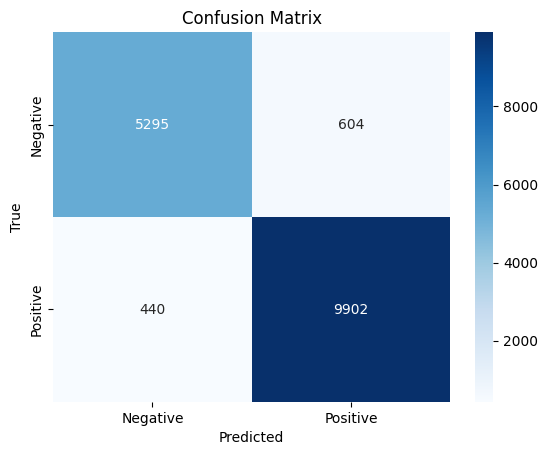

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


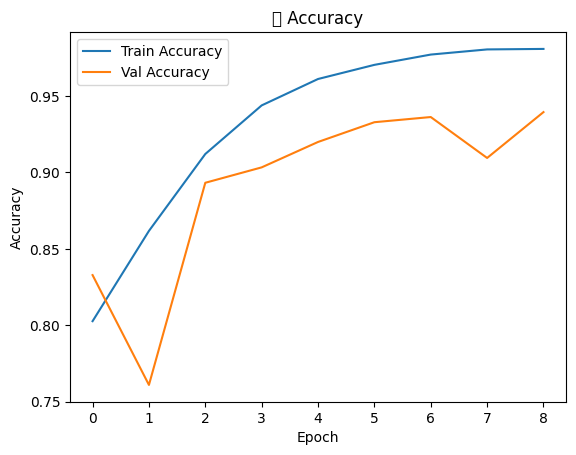

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


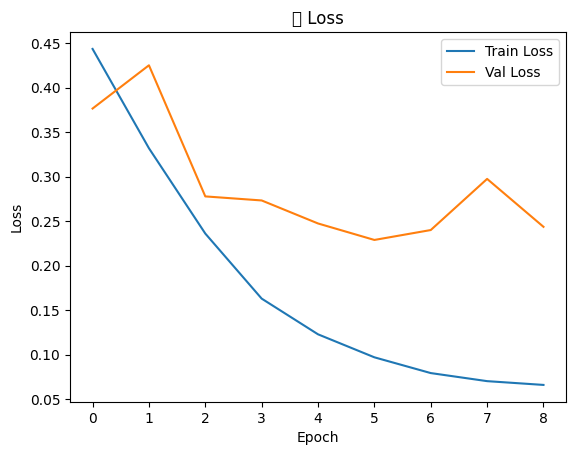

In [26]:

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("📈 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("📉 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [27]:
def preprocess_and_predict(text, model, tokenizer, max_len=100):



    text = text.lower()

    text = re.sub(r"http\S+|@\w+|#\w+|[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)


    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords.words('english') and len(t) > 2]


    text_seq = tokenizer.texts_to_sequences([" ".join(tokens)])
    padded = pad_sequences(text_seq, maxlen=max_len, padding='post')


    prediction = model.predict(padded)[0][0]
    label = "positive 😊" if prediction >= 0.5 else "negative 😠"
    confidence = round(prediction*100 if prediction >= 0.5 else (1 - prediction)*100, 2)

    print(f"\n🧪 text: {text}")
    print(f"🔍 result: {label} ({confidence}٪ )")

In [28]:
preprocess_and_predict("i dont know who i am.this is bollshit", model, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

🧪 text: i dont know who i amthis is bollshit
🔍 result: negative 😠 (97.97٪ )


In [29]:
# LSTM → CNN
model_lstm_cnn = Sequential()
model_lstm_cnn.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=MAX_LEN,
    trainable=False
))

model_lstm_cnn.add(LSTM(128, return_sequences=True))
model_lstm_cnn.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model_lstm_cnn.add(MaxPooling1D(pool_size=2))
model_lstm_cnn.add(Flatten())
model_lstm_cnn.add(Dropout(0.5))
model_lstm_cnn.add(Dense(64, activation='relu'))
model_lstm_cnn.add(Dense(1, activation='sigmoid'))


model_lstm_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_lstm_cnn = model_lstm_cnn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


813/813 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8029 - loss: 0.4303 - val_accuracy: 0.8093 - val_loss: 0.4459
Epoch 2/10
813/813 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8390 - loss: 0.3633 - val_accuracy: 0.8505 - val_loss: 0.3432
Epoch 3/10
813/813 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8660 - loss: 0.3135 - val_accuracy: 0.8667 - val_loss: 0.3121
Epoch 4/10
813/813 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8816 - loss: 0.2776 - val_accuracy: 0.8706 - val_loss: 0.3126
Epoch 5/10
813/813 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9017 - loss: 0.2377 - val_accuracy: 0.8735 - val_loss: 0.3015
Epoch 6/10
813/813 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9145 - loss: 0.2092 - val_accuracy: 0.8992 - val_loss: 0.2505
Epoch 7/10
813/813 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9355 - loss: 0.1600 - val_accuracy: 0.9071 - val_loss: 0.2517
Epoch 8/10
813/813 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9491 - loss: 0.1335 - val_accuracy: 

In [30]:

loss2, accuracy2 = model_lstm_cnn.evaluate(X_test, y_test)
print(f"\n🎯 Test Accuracy (LSTM→CNN): {accuracy2:.4f}")
print(f"🧮 Test Loss: {loss2:.4f}")


y_pred2 = (model_lstm_cnn.predict(X_test) > 0.5).astype("int32")
print("\n🧾 report:")
print(classification_report(y_test, y_pred2, target_names=["Negative", "Positive"]))

508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9087 - loss: 0.2383

🎯 Test Accuracy (LSTM→CNN): 0.9029
🧮 Test Loss: 0.2442
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

🧾 report:
              precision    recall  f1-score   support

    Negative       0.90      0.83      0.86      5899
    Positive       0.90      0.95      0.93     10342

    accuracy                           0.90     16241
   macro avg       0.90      0.89      0.89     16241
weighted avg       0.90      0.90      0.90     16241



508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


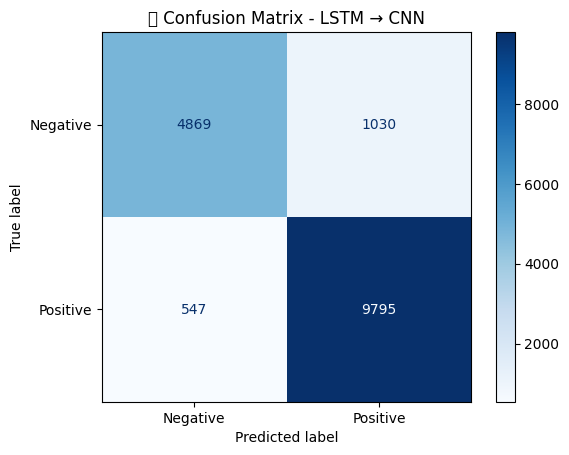

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


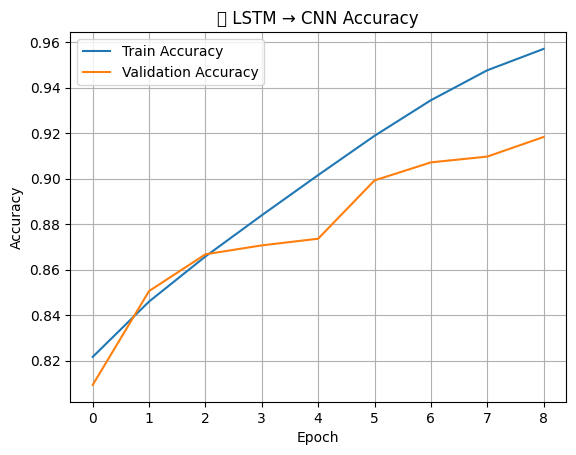

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


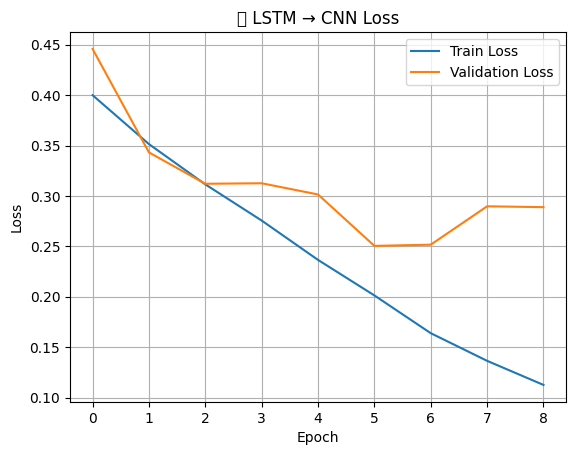

In [31]:

y_pred_lstm_cnn = (model_lstm_cnn.predict(X_test) > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred_lstm_cnn)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues')
plt.title("📊 Confusion Matrix - LSTM → CNN")
plt.grid(False)
plt.show()


plt.plot(history_lstm_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title("📈 LSTM → CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


plt.plot(history_lstm_cnn.history['loss'], label='Train Loss')
plt.plot(history_lstm_cnn.history['val_loss'], label='Validation Loss')
plt.title("📉 LSTM → CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
def predict_sentiment(text, model, tokenizer, max_len=100):

    nltk.download('punkt')
    nltk.download('stopwords')


    text = text.lower()
    text = re.sub(r"http\S+|@\w+|#\w+|[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)


    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stopwords.words('english') and len(t) > 2]


    sequence = tokenizer.texts_to_sequences([" ".join(tokens)])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post')


    prob = model.predict(padded)[0][0]
    label = "positive 😊" if prob >= 0.5 else "nigative 😠"
    confidence = round(prob * 100 if prob >= 0.5 else (1 - prob) * 100, 2)


    print(f"\n📝 text: {text}")
    print(f"🔍 result: {label}")
    print(f"📊 Confidence: {confidence}%")

In [21]:
predict_sentiment("I really love the new design of this product", model_lstm_cnn, tokenizer)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

📝 text: i really love the new design of this product
🔍 result: positive 😊
📊 Confidence: 100.0%


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


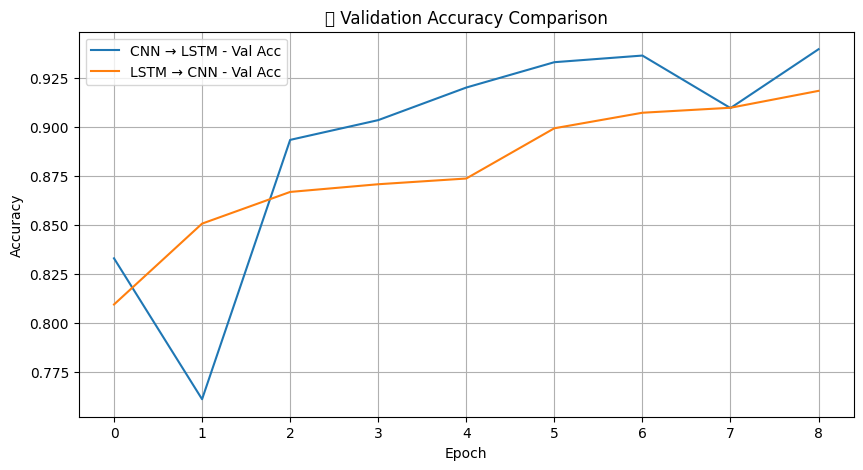

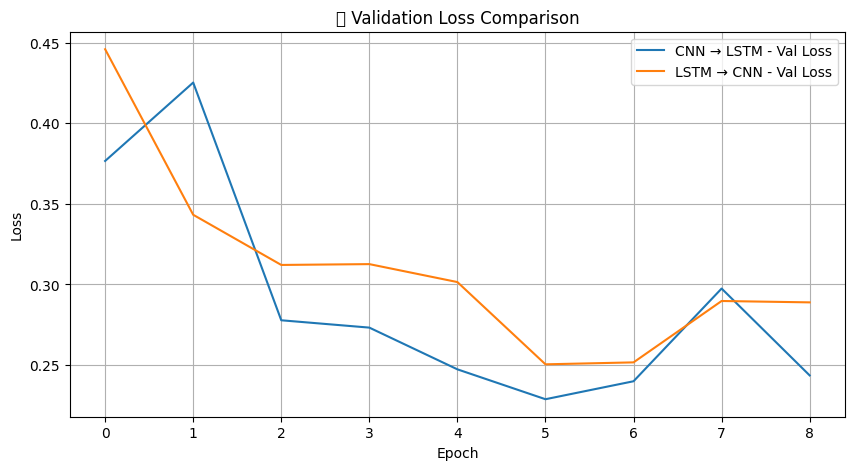

In [33]:



plt.figure(figsize=(10, 5))
plt.plot(history.history['val_accuracy'], label='CNN → LSTM - Val Acc')
plt.plot(history_lstm_cnn.history['val_accuracy'], label='LSTM → CNN - Val Acc')
plt.title("🔍 Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(history.history['val_loss'], label='CNN → LSTM - Val Loss')
plt.plot(history_lstm_cnn.history['val_loss'], label='LSTM → CNN - Val Loss')
plt.title("📉 Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()